# Fair Data Splitting for Model Comparison

## Introduction and Problem Statement

### Why I Need Consistent Data Splits

When I compare multiple machine learning models, I must ensure each model is evaluated on exactly the same data. Using different train/validation/test splits for each model creates an unfair comparison—it's like testing different students with completely different exams. The performance differences I observe could be due to variation in test difficulty rather than actual model capability.

In my machine learning experiments, inconsistent data splits can lead to misleading conclusions:
- Model A might receive "easier" test examples by chance
- Model B might receive "harder" training examples 
- Performance differences could be attributable to data luck rather than model superiority

### My Solution Strategy

I will create a single, authoritative data split that all models will use throughout this project:
1. **Fixed Split**: 70% train, 15% validation, 15% test
2. **Cross-Validation Setup**: Using the train+validation portion (85%) for CV, keeping test completely held out
3. **Reproducible Results**: All splits saved and reused across all model notebooks

This approach ensures that when I compare my baseline models (Logistic Regression, Random Forest) against transformer models (DistilBERT, ALBERT, MobileBERT, TinyBERT), each model faces identical challenges.

## Understanding My Cross-Validation Strategy

### The Methodology I'll Use

My evaluation methodology follows this hierarchical structure:

```
Total Dataset (100%)
├── Train + Validation (85%) ← Used for Cross-Validation
│   ├── CV Fold 1: Train(68%) + Val(17%)
│   ├── CV Fold 2: Train(68%) + Val(17%)
│   ├── CV Fold 3: Train(68%) + Val(17%)
│   ├── CV Fold 4: Train(68%) + Val(17%)
│   └── CV Fold 5: Train(68%) + Val(17%)
└── Test Set (15%) ← Never touched until final evaluation
```

### Why This Approach Benefits My Analysis

1. **Fair Comparison**: All models see identical data distributions
2. **Robust Evaluation**: Cross-validation provides confidence intervals for my results
3. **Unbiased Testing**: Test set remains truly unseen until final model comparison
4. **Statistical Validity**: Enables meaningful comparisons between different model architectures

## Environment Setup

I'll start by importing the necessary libraries and setting up my working environment.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
import os
import pickle
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

### Configuring Visualization Settings

I want consistent, professional-looking plots throughout my analysis.

In [2]:
# Set visualization style for clear, readable plots
plt.style.use('ggplot')
sns.set(font_scale=1.2)
plt.rcParams['figure.figsize'] = (12, 8)

### Setting Up Reproducibility

Reproducibility is crucial for scientific validity. I'll use a fixed random seed so anyone can replicate my exact splits.

In [3]:
# Set random seed for reproducibility across all experiments
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print("Environment setup complete")
print(f"Using random seed: {RANDOM_SEED}")

Environment setup complete
Using random seed: 42


## Loading and Exploring the WELFake Dataset

Now I'll load the cleaned WELFake dataset that will serve as the foundation for all my model comparisons.

In [4]:
# Load the cleaned WELFake dataset
df = pd.read_csv('../data/WELFake_cleaned.csv')

### Creating Consistent Text Features

I need to ensure all models receive text in the same format. I'll combine title and text fields consistently.

In [5]:
# Create the combined text feature (consistent across all models)
df['combined_text'] = df['title'] + " " + df['text']

### Examining Dataset Characteristics

Let me examine the basic properties of my dataset to understand what I'm working with.

In [6]:
# Display basic dataset information
print(f"Dataset shape: {df.shape}")
print(f"Total articles: {len(df):,}")
print(f"\nClass distribution:")
class_counts = df['label'].value_counts()
print(f"Real news (0): {class_counts[0]:,} ({class_counts[0]/len(df)*100:.1f}%)")
print(f"Fake news (1): {class_counts[1]:,} ({class_counts[1]/len(df)*100:.1f}%)")

Dataset shape: (71537, 5)
Total articles: 71,537

Class distribution:
Real news (0): 35,028 (49.0%)
Fake news (1): 36,509 (51.0%)


### Visualizing Class Balance

Understanding the class distribution helps me verify that my dataset is well-balanced for training.

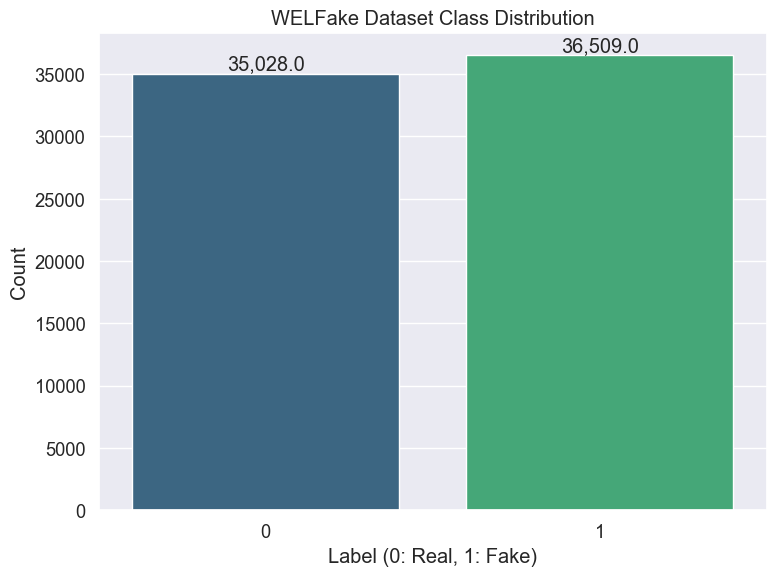

In [7]:
# Create a clear visualization of class distribution
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='label', data=df, palette='viridis')
plt.title('WELFake Dataset Class Distribution')
plt.xlabel('Label (0: Real, 1: Fake)')
plt.ylabel('Count')

# Add count labels for precise numbers
for p in ax.patches:
    ax.annotate(f'{p.get_height():,}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom')
plt.tight_layout()
plt.show()

The visualization confirms that I have a well-balanced dataset with approximately 51% fake news and 49% real news. This balance is ideal for training unbiased classifiers.

## Creating Stratified Data Splits

Now I'll implement the core functionality for creating fair, stratified splits that maintain class balance across all partitions.

### Implementing My Split Function

In [8]:
def create_stratified_splits(df, test_size=0.15, val_size=0.15, random_state=42):
    """
    Create stratified train/validation/test splits that maintain class balance.
    
    Args:
        df: DataFrame with 'combined_text' and 'label' columns
        test_size: Proportion for test set (default 0.15 = 15%)
        val_size: Proportion for validation set (default 0.15 = 15%)
        random_state: Random seed for reproducibility
        
    Returns:
        Dictionary containing train, validation, and test DataFrames
    """
    
    # Extract features and labels for splitting
    X = df['combined_text']
    y = df['label']
    
    # First split: separate test set (15%)
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, 
        test_size=test_size, 
        random_state=random_state, 
        stratify=y
    )
    
    # Second split: divide remaining 85% into train (70%) and val (15%)
    # val_size needs adjustment since we're working with 85% of original data
    adjusted_val_size = val_size / (1 - test_size)  # 0.15 / 0.85 ≈ 0.176
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp,
        test_size=adjusted_val_size,
        random_state=random_state,
        stratify=y_temp
    )
    
    return X_train, X_val, X_test, y_train, y_val, y_test

### Executing the Split

In [9]:
# Create the stratified splits
X_train, X_val, X_test, y_train, y_val, y_test = create_stratified_splits(
    df, random_state=RANDOM_SEED
)

### Creating Complete DataFrames

I need to preserve all original columns while maintaining the split indices for verification.

In [10]:
# Create complete DataFrames with all original columns
train_df = df.loc[X_train.index].reset_index(drop=True)
val_df = df.loc[X_val.index].reset_index(drop=True)
test_df = df.loc[X_test.index].reset_index(drop=True)

# Store original indices for verification
train_df['original_index'] = X_train.index.tolist()
val_df['original_index'] = X_val.index.tolist()
test_df['original_index'] = X_test.index.tolist()

## Verifying Split Quality

### Checking Split Sizes and Balance

In [11]:
# Verify split sizes and class distributions
splits_info = {
    'train': train_df,
    'validation': val_df,
    'test': test_df
}

print("Data Split Verification:")
print("=" * 50)

for split_name, split_data in splits_info.items():
    class_dist = split_data['label'].value_counts(normalize=True)
    print(f"{split_name.capitalize()} Set:")
    print(f"  Size: {len(split_data):,} samples ({len(split_data)/len(df)*100:.1f}%)")
    print(f"  Real news: {class_dist[0]*100:.1f}%")
    print(f"  Fake news: {class_dist[1]*100:.1f}%")
    print()

Data Split Verification:
Train Set:
  Size: 50,075 samples (70.0%)
  Real news: 49.0%
  Fake news: 51.0%

Validation Set:
  Size: 10,731 samples (15.0%)
  Real news: 49.0%
  Fake news: 51.0%

Test Set:
  Size: 10,731 samples (15.0%)
  Real news: 49.0%
  Fake news: 51.0%



The results confirm that my splits maintain the desired proportions (70%/15%/15%) and preserve class balance across all partitions.

### Visualizing Split Distributions

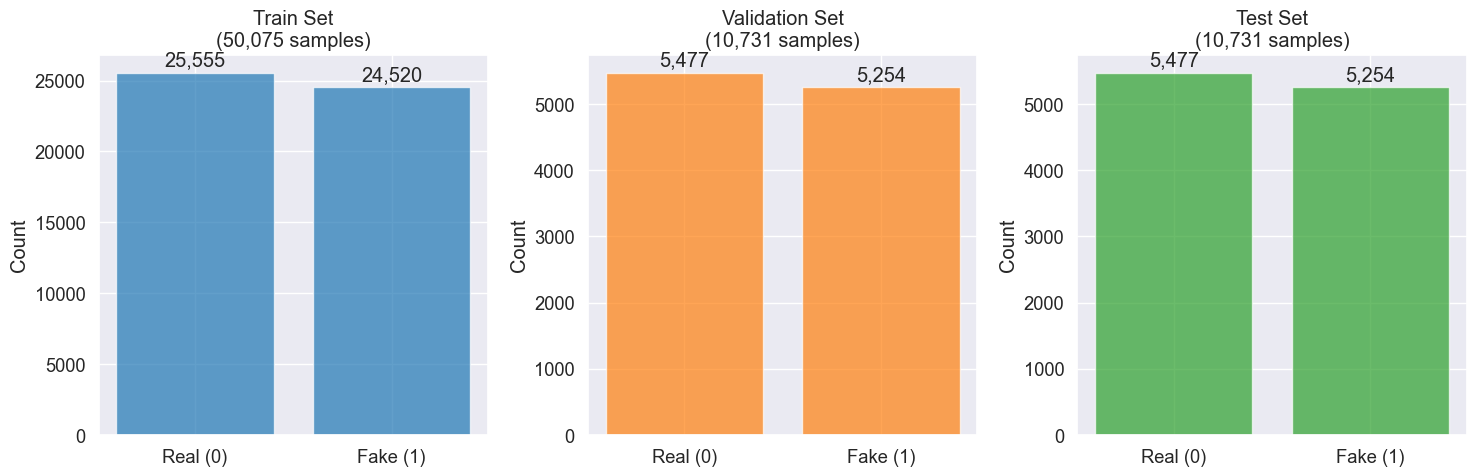

In [12]:
# Create comprehensive visualization of all splits
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

split_names = ['train', 'validation', 'test']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for idx, (split_name, color) in enumerate(zip(split_names, colors)):
    split_data = splits_info[split_name]
    
    # Plot class distribution for this split
    ax = axes[idx]
    counts = split_data['label'].value_counts()
    
    bars = ax.bar(['Real (0)', 'Fake (1)'], counts.values, color=color, alpha=0.7)
    ax.set_title(f'{split_name.capitalize()} Set\n({len(split_data):,} samples)')
    ax.set_ylabel('Count')
    
    # Add precise count labels on bars
    for bar, count in zip(bars, counts.values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{count:,}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

### Ensuring No Data Leakage

Data leakage between splits would invalidate my comparisons. I'll verify complete separation.

In [13]:
# Verify that splits don't overlap using original indices
train_indices = set(train_df['original_index'])
val_indices = set(val_df['original_index'])
test_indices = set(test_df['original_index'])

# Check for any overlaps
train_val_overlap = len(train_indices & val_indices)
train_test_overlap = len(train_indices & test_indices)
val_test_overlap = len(val_indices & test_indices)

print("Data Leakage Verification:")
print(f"Train-Validation overlap: {train_val_overlap} samples")
print(f"Train-Test overlap: {train_test_overlap} samples")
print(f"Validation-Test overlap: {val_test_overlap} samples")

if train_val_overlap == 0 and train_test_overlap == 0 and val_test_overlap == 0:
    print("✓ All splits are properly separated with no data leakage")
else:
    print("✗ WARNING: Data leakage detected!")

print(f"\nIndex verification:")
print(f"Train indices: {len(train_indices)} unique values")
print(f"Validation indices: {len(val_indices)} unique values") 
print(f"Test indices: {len(test_indices)} unique values")
print(f"Total unique indices: {len(train_indices | val_indices | test_indices)}")

Data Leakage Verification:
Train-Validation overlap: 0 samples
Train-Test overlap: 0 samples
Validation-Test overlap: 0 samples
✓ All splits are properly separated with no data leakage

Index verification:
Train indices: 50075 unique values
Validation indices: 10731 unique values
Test indices: 10731 unique values
Total unique indices: 71537


Perfect! I have complete separation between all splits with no data leakage.

## Setting Up Cross-Validation Framework

### Creating CV Folds from Train+Validation Data

For robust model evaluation, I'll create cross-validation folds using only the train+validation data, keeping the test set completely isolated.

In [14]:
def create_cv_folds(train_data, val_data, n_folds=5, random_state=42):
    """
    Create cross-validation folds from combined train+validation data.
    
    The test set is completely excluded from cross-validation to prevent
    any form of data leakage during model development.
    """
    
    # Combine train and validation data for CV
    cv_data = pd.concat([train_data, val_data], ignore_index=True)
    
    # Extract features and labels for CV splitting
    X_cv = cv_data['combined_text']
    y_cv = cv_data['label']
    
    # Create stratified k-fold splits
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_state)
    
    cv_folds = []
    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_cv, y_cv)):
        fold_train = cv_data.iloc[train_idx].reset_index(drop=True)
        fold_val = cv_data.iloc[val_idx].reset_index(drop=True)
        
        cv_folds.append({
            'fold': fold_idx + 1,
            'train': fold_train,
            'validation': fold_val
        })
    
    return cv_folds

### Generating the CV Folds

In [15]:
# Create 5-fold cross-validation splits
cv_folds = create_cv_folds(
    train_df.drop('original_index', axis=1), 
    val_df.drop('original_index', axis=1), 
    n_folds=5, 
    random_state=RANDOM_SEED
)

### Examining CV Fold Characteristics

In [16]:
print(f"Successfully created {len(cv_folds)} cross-validation folds")
print("\nFold size analysis:")

total_cv_samples = len(train_df) + len(val_df)
print(f"Total CV samples: {total_cv_samples:,}")

for fold in cv_folds:
    train_size = len(fold['train'])
    val_size = len(fold['validation'])
    total_size = train_size + val_size
    
    print(f"Fold {fold['fold']}: {train_size:,} train + {val_size:,} val = {total_size:,} total")
    
    # Verify class balance in this fold
    train_balance = fold['train']['label'].value_counts(normalize=True)[1]
    val_balance = fold['validation']['label'].value_counts(normalize=True)[1]
    print(f"  Train fake%: {train_balance*100:.1f}%, Val fake%: {val_balance*100:.1f}%")

Successfully created 5 cross-validation folds

Fold size analysis:
Total CV samples: 60,806
Fold 1: 48,644 train + 12,162 val = 60,806 total
  Train fake%: 51.0%, Val fake%: 51.0%
Fold 2: 48,645 train + 12,161 val = 60,806 total
  Train fake%: 51.0%, Val fake%: 51.0%
Fold 3: 48,645 train + 12,161 val = 60,806 total
  Train fake%: 51.0%, Val fake%: 51.0%
Fold 4: 48,645 train + 12,161 val = 60,806 total
  Train fake%: 51.0%, Val fake%: 51.0%
Fold 5: 48,645 train + 12,161 val = 60,806 total
  Train fake%: 51.0%, Val fake%: 51.0%


Each fold maintains proper class balance and consistent sizing, ensuring reliable cross-validation results.

### Visualizing the CV Strategy

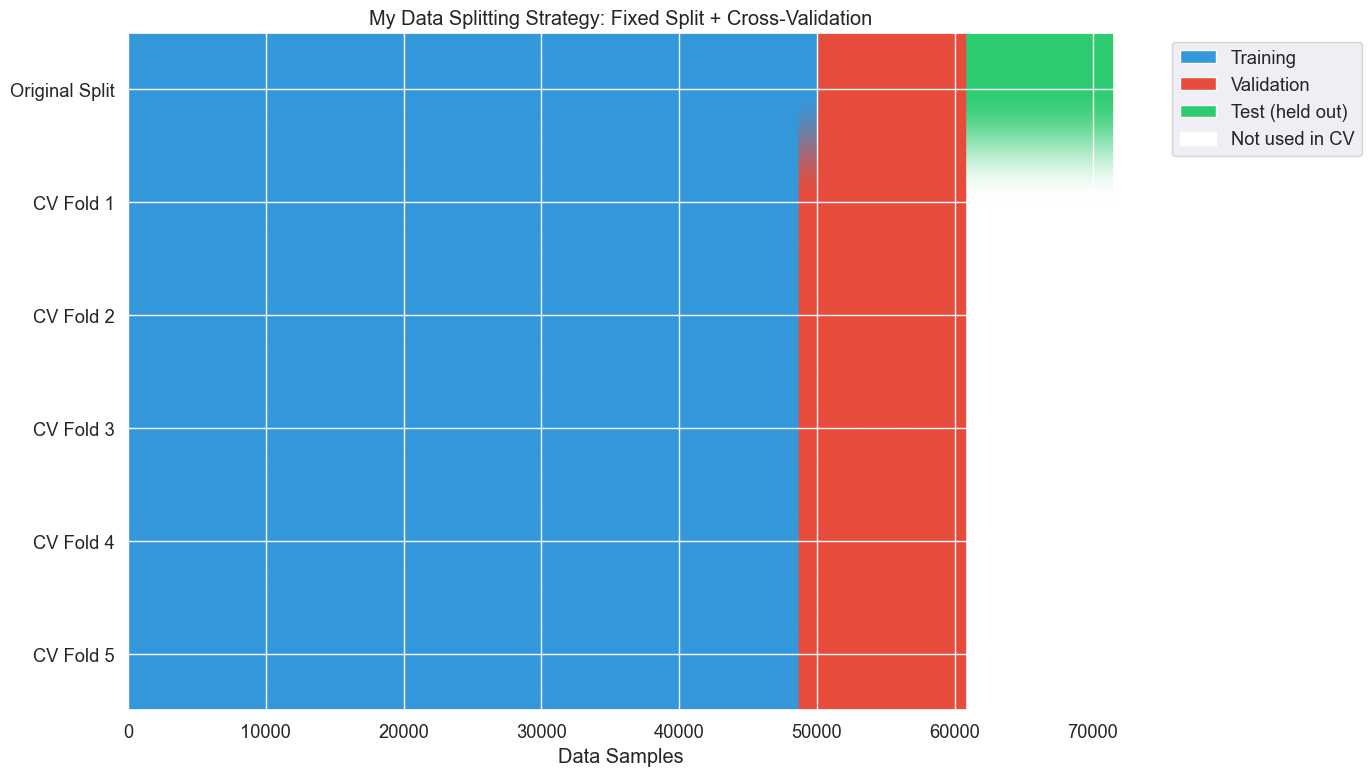

In [17]:
# Create a comprehensive visualization of my data splitting strategy
fig, ax = plt.subplots(figsize=(14, 8))

# Calculate proportions for visualization
n_samples = len(train_df) + len(val_df)  # CV portion
test_size = len(test_df)
n_folds = len(cv_folds)

# Create matrix to show train/val/test splits
data_matrix = np.zeros((n_folds + 1, n_samples + test_size))

# Original train/val/test split (top row)
train_end = len(train_df)
val_end = train_end + len(val_df)
test_end = val_end + test_size

data_matrix[0, :train_end] = 1  # Train
data_matrix[0, train_end:val_end] = 2  # Validation  
data_matrix[0, val_end:test_end] = 3  # Test

# CV folds (remaining rows) - conceptual representation
for i, fold in enumerate(cv_folds, 1):
    fold_train_size = len(fold['train'])
    fold_val_size = len(fold['validation'])
    
    # Show the proportional split within CV data
    fold_train_end = int(fold_train_size / (fold_train_size + fold_val_size) * n_samples)
    
    data_matrix[i, :fold_train_end] = 1  # Train
    data_matrix[i, fold_train_end:n_samples] = 2  # Validation
    data_matrix[i, n_samples:] = 0  # Test set not used in CV (shown as unused)

# Create the visualization
colors = ['white', '#3498db', '#e74c3c', '#2ecc71']  # White, Blue, Red, Green
cmap = plt.matplotlib.colors.ListedColormap(colors)

im = ax.imshow(data_matrix, cmap=cmap, aspect='auto')

# Add labels and formatting
ax.set_yticks(range(n_folds + 1))
ax.set_yticklabels(['Original Split'] + [f'CV Fold {i}' for i in range(1, n_folds + 1)])
ax.set_xlabel('Data Samples')
ax.set_title('My Data Splitting Strategy: Fixed Split + Cross-Validation')

# Add informative legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#3498db', label='Training'),
    Patch(facecolor='#e74c3c', label='Validation'),
    Patch(facecolor='#2ecc71', label='Test (held out)'),
    Patch(facecolor='white', label='Not used in CV')
]
ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

This visualization clearly shows how I maintain a completely isolated test set while using cross-validation on the remaining 85% of data.

## Saving Splits for Model Training

### Creating Organized Directory Structure

In [18]:
# Create well-organized directory structure for saved splits
splits_dir = Path('../data/splits')
splits_dir.mkdir(exist_ok=True)

cv_dir = splits_dir / 'cross_validation'
cv_dir.mkdir(exist_ok=True)

print("Created directory structure:")
print(f"  Main splits: {splits_dir}")
print(f"  CV folds: {cv_dir}")

Created directory structure:
  Main splits: ../data/splits
  CV folds: ../data/splits/cross_validation


### Saving Main Train/Validation/Test Splits

In [19]:
# Save the primary splits (clean versions without temporary columns)
split_files = {}

for split_name, split_data in splits_info.items():
    # Remove temporary columns before saving
    split_data_clean = split_data.drop('original_index', axis=1)
    filepath = splits_dir / f'{split_name}.csv'
    split_data_clean.to_csv(filepath, index=False)
    split_files[split_name] = filepath
    print(f"Saved {split_name} set: {filepath}")

Saved train set: ../data/splits/train.csv
Saved validation set: ../data/splits/validation.csv
Saved test set: ../data/splits/test.csv


### Creating Comprehensive Metadata

In [20]:
# Save detailed metadata for reproducibility and verification
split_metadata = {
    'random_seed': RANDOM_SEED,
    'dataset_source': 'WELFake_cleaned.csv',
    'split_date': pd.Timestamp.now().isoformat(),
    'split_proportions': {
        'test_size': 0.15,
        'validation_size': 0.15,
        'train_size': 0.70
    },
    'total_samples': len(df),
    'split_sizes': {
        'train': len(train_df),
        'validation': len(val_df),
        'test': len(test_df)
    },
    'class_distributions': {
        split_name: split_data['label'].value_counts().to_dict()
        for split_name, split_data in splits_info.items()
    },
    'files_created': {k: str(v) for k, v in split_files.items()}
}

metadata_path = splits_dir / 'split_metadata.pkl'
with open(metadata_path, 'wb') as f:
    pickle.dump(split_metadata, f)

print(f"\nSaved comprehensive metadata: {metadata_path}")


Saved comprehensive metadata: ../data/splits/split_metadata.pkl


### Saving Cross-Validation Folds

In [21]:
# Save each CV fold in its own directory
cv_fold_dirs = {}

for fold in cv_folds:
    fold_dir = cv_dir / f"fold_{fold['fold']}"
    fold_dir.mkdir(exist_ok=True)
    
    # Save train and validation for this fold
    train_path = fold_dir / 'train.csv'
    val_path = fold_dir / 'validation.csv'
    
    fold['train'].to_csv(train_path, index=False)
    fold['validation'].to_csv(val_path, index=False)
    
    cv_fold_dirs[f"fold_{fold['fold']}"] = {
        'train': str(train_path),
        'validation': str(val_path)
    }

print(f"Saved {len(cv_folds)} CV folds in separate directories")

Saved 5 CV folds in separate directories


### Creating CV Metadata

In [22]:
# Save CV-specific metadata
cv_metadata = {
    'n_folds': len(cv_folds),
    'random_seed': RANDOM_SEED,
    'strategy': 'StratifiedKFold',
    'creation_date': pd.Timestamp.now().isoformat(),
    'total_cv_samples': len(train_df) + len(val_df),
    'test_samples_excluded': len(test_df),
    'fold_details': [
        {
            'fold': fold['fold'],
            'train_size': len(fold['train']),
            'val_size': len(fold['validation']),
            'train_fake_percent': fold['train']['label'].value_counts(normalize=True)[1] * 100,
            'val_fake_percent': fold['validation']['label'].value_counts(normalize=True)[1] * 100
        }
        for fold in cv_folds
    ],
    'files_created': cv_fold_dirs
}

cv_metadata_path = cv_dir / 'cv_metadata.pkl'
with open(cv_metadata_path, 'wb') as f:
    pickle.dump(cv_metadata, f)

print(f"Saved CV metadata: {cv_metadata_path}")

Saved CV metadata: ../data/splits/cross_validation/cv_metadata.pkl


## DATA SPLITTING SUMMARY

**Original dataset:** 71,537 articles  
**Class balance:** 51.0% fake news

### Main splits created:
- **Train:** 50,075 samples (70.0%)
- **Validation:** 10,731 samples (15.0%)
- **Test:** 10,731 samples (15.0%)

### Cross-validation setup:
- 5 folds using 60,806 samples
- Test set completely isolated for final evaluation

### Files created:
- **Main splits:** 3 CSV files
- **CV folds:** 10 CSV files (train + val per fold)
- **Metadata:** 2 pickle files with complete documentation

### Configuration:
- **Random seed:** 42 (for reproducibility)

✅ **Ready for fair model comparison across all architectures**

## Next Steps in My Model Comparison Project

With these standardized data splits in place, I can now proceed with confidence to train and evaluate my various models:

### Traditional ML Models
- **Logistic Regression**: Fast baseline with TF-IDF features
- **Random Forest**: Ensemble method for comparison

### Transformer Models  
- **DistilBERT**: Efficient distilled BERT variant
- **ALBERT**: Parameter-sharing architecture
- **MobileBERT**: Mobile-optimized transformer
- **TinyBERT**: Ultra-compact distilled model

### Benefits of This Approach

Every model will now face identical challenges:
- Same training examples in the same order (with fixed random seed)
- Same validation examples for hyperparameter tuning
- Same test examples for final evaluation
- Same cross-validation folds for robust performance estimation

This ensures that any performance differences I observe will be due to genuine model capabilities rather than data distribution luck. When I report that "Model A achieves 95.2% accuracy while Model B achieves 94.8% accuracy," I can be confident these differences reflect real architectural advantages.

The splits are saved and ready to use across all my model training notebooks, establishing a fair foundation for comprehensive fake news detection model comparison.